In [304]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
import os
import pickle

# Load your train_df (assuming it's available in the same directory)
train_df = pd.read_csv('Combined Data/train_df.csv')  # Change to your path

# Load and preprocess image data
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image / 255.0  # Normalize to [0, 1]
    return image

# Prepare image data and scalar features
image_dir = 'Combined Data/train_images'  # Update this path to where your images are stored
image_paths = []
scalar_features = []
labels = []

for index, row in train_df.iterrows():
    pothole_id = row['pothole_id']
    image_path = os.path.join(image_dir, f'{pothole_id}.jpg')
    
    if os.path.exists(image_path):
        image_paths.append(image_path)
        scalar_features.append([row['pothole_area_mm2']])
        labels.append(row['bags_used'])

# Convert lists to numpy arrays
images = np.array([load_and_preprocess_image(path) for path in image_paths])
scalar_features = np.array(scalar_features)
labels = np.array(labels)

# Loading Model

In [305]:
# Model creation
def create_model(input_shape_image, input_shape_scalar):
    # Image processing layers
    image_input = Input(shape=input_shape_image)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(image_input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)

    # Scalar features processing layers
    scalar_input = Input(shape=input_shape_scalar)
    y = Dense(32, activation='relu')(scalar_input)
    y = Dropout(0.5)(y)
    y = BatchNormalization()(y)

    # Combine the outputs
    combined = Concatenate()([x, y])
    combined = Dense(64, activation='relu')(combined)
    combined = Dropout(0.5)(combined)
    combined = BatchNormalization()(combined)

    # Output layer with ReLU to ensure non-negative predictions
    output = Dense(1, activation='relu')(combined)

    # Create the model
    model = Model(inputs=[image_input, scalar_input], outputs=output)

    return model

# Model creation
input_shape_image = (224, 224, 3)
input_shape_scalar = (scalar_features.shape[1],)
model = create_model(input_shape_image, input_shape_scalar)

In [306]:
# Load the saved weights
checkpoint_path = 'models/my_model.h5'  # Replace with your actual path
model.load_weights(checkpoint_path)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4), loss='mse', metrics=['mse'])

In [307]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = image / 255.0  # Normalize to [0, 1]
    return image

In [308]:
scaler_path = 'models/scaler.pkl'

# Load the scaler
with open(scaler_path, 'rb') as f:
    scaler = pickle.load(f)

print("Scaler loaded successfully!")

Scaler loaded successfully!


/Users/christiaanhildebrand/anaconda3/envs/Main/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# Loading Data

In [309]:
train_df = pd.read_csv('Combined Data/train_df.csv')
test_df = pd.read_csv('Combined Data/test_df.csv')

In [310]:
train_df.head()

,pothole_id,mm_to_pixel_ratio,pothole_length,pothole_width,pothole_area_mm2,bags_used
0,p1036,2.024225,256,174,1.143629e+05,0.5
1,p1022,2.233278,769,518,1.685416e+06,2.0
2,p417,2.744603,298,218,3.453620e+05,0.5
3,p1552,1.583786,490,296,2.060394e+05,0.5
4,p1234,4.087254,245,326,8.128550e+05,1.0


1/1 [==============================] - 0s 55ms/step


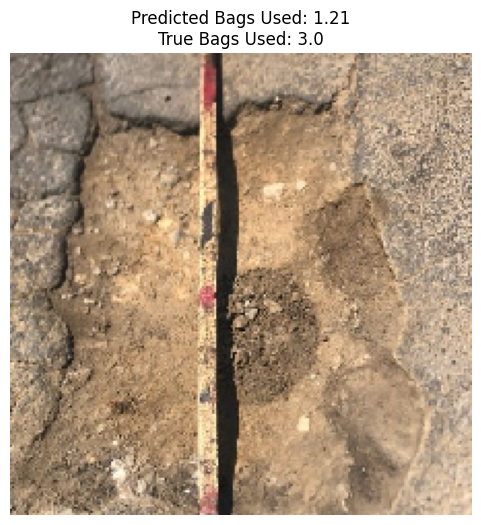

In [311]:
random_index = random.randint(0, len(train_df) - 1)
selected_row = train_df.iloc[random_index]

# Extract the image path
image_dir = 'Combined Data/valid_images'
image_path = os.path.join(image_dir, f"{selected_row['pothole_id']}.jpg")

# Load and preprocess the image
new_image = load_and_preprocess_image(image_path)
new_image = np.expand_dims(new_image, axis=0)  # Add batch dimension

# Extract and scale the scalar feature
new_scalar_features = [[selected_row['pothole_area_mm2']]]
scaled_features = scaler.transform(new_scalar_features)

# Predict using the model
predicted_bags_used = model.predict([new_image, scaled_features])

# Get the true value
true_bags_used = selected_row['bags_used']

# Display the image with prediction and true value
plt.figure(figsize=(6, 6))
plt.imshow(np.squeeze(new_image))
plt.title(f"Predicted Bags Used: {predicted_bags_used[0][0]:.2f}\nTrue Bags Used: {true_bags_used}")
plt.axis('off')
plt.show()

In [312]:
random_index = random.randint(0, len(test_df) - 1)
selected_row = test_df.iloc[random_index]

# Extract the image path
image_dir = '../../data/Patch Perfect Data/test_images'
image_path = os.path.join(image_dir, f"{selected_row['pothole_id']}.jpg")

# Load and preprocess the image
new_image = load_and_preprocess_image(image_path)
new_image = np.expand_dims(new_image, axis=0)  # Add batch dimension

# Extract and scale the scalar features
new_scalar_features = [[
    selected_row['pothole_area_mm2'], 
    selected_row['pothole_length'], 
    selected_row['pothole_width'], 
    selected_row['mm_to_pixel_ratio']
]]
scaled_features = scaler.transform(new_scalar_features)

# Predict using the model
predicted_bags_used = model.predict([new_image, scaled_features])

# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(np.squeeze(new_image))
plt.title(f"Predicted Bags Used: {predicted_bags_used[0][0]:.2f}")
plt.axis('off')
plt.show()

ValueError: X has 4 features, but StandardScaler is expecting 1 features as input.

In [ ]:
train_df['bags_used'].value_counts().sort_index()

# Making Prediction Dataset

In [329]:
# Create an empty DataFrame to store predictions
pred_df = pd.DataFrame(columns=['pothole_id', 'predicted_bags_used'])

# List to store individual prediction results
predictions = []
image_dir = 'Combined Data/test_images'

# Loop through each row in test_df
for idx, row in test_df.iterrows():
    pothole_id = row['pothole_id']
    
    # Construct the image path
    image_path = os.path.join(image_dir, f"{pothole_id}.jpg")
    
    # Load and preprocess the image
    new_image = load_and_preprocess_image(image_path)
    new_image = np.expand_dims(new_image, axis=0)  # Add batch dimension
    
    # Extract and scale the scalar feature (only pothole_area_mm2)
    new_scalar_features = [[row['pothole_area_mm2']]]
    scaled_features = scaler.transform(new_scalar_features)
    
    # Predict using the model
    predicted_bags_used = model.predict([new_image, scaled_features])[0][0]
    
    # Store the result in the list
    predictions.append({
        'pothole_id': pothole_id,
        'predicted_bags_used': predicted_bags_used
    })

# Convert the list of predictions to a DataFrame and concatenate
pred_df = pd.concat([pred_df, pd.DataFrame(predictions)], ignore_index=True)

# Display the first few rows of the prediction DataFrame
print(pred_df.head())


1/1 [==============================] - 0s 10ms/step
  pothole_id  predicted_bags_used
0      p1181             0.198906
1      p1430             0.000000
2      p1409             0.000000
3       p406             1.484055
4       p104             0.117062


/var/folders/cn/l2w87hs522x2cpq6dw6dslqh0000gn/T/ipykernel_26311/3555253983.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pred_df = pd.concat([pred_df, pd.DataFrame(predictions)], ignore_index=True)


In [324]:
pred_df['predicted_bags_used'].replace(0,0.25,inplace=True)

In [330]:
pred_df.columns = ['Pothole number', 'Bags used ']
pred_df['Pothole number'] = pred_df['Pothole number'].str.lstrip('p')

In [331]:
pred_df.set_index('Pothole number', inplace=True)

In [332]:
pred_df.to_csv('../../data/predictions/CNN1.csv')

In [333]:
pred_df.head(30).sort_index()

,Bags used
Pothole number,
103,0.706096
104,0.117062
1040,0.169638
105,0.504365
108,0.000000
1086,0.000000
1115,0.121490
1134,0.000000
114,1.268170


In [334]:
pred

NameError: name 'pred' is not defined